# Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [7]:
df=pd.read_csv("C:\\New folder (3)\\churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [47]:
df.shape

(10000, 11)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  float64
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  float64
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 859.5+ KB


In [49]:
df.describe(include='object')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [50]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.561300,38.660800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.558702,9.746704,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,383.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,62.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Exploratory Data Analysis

In [51]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

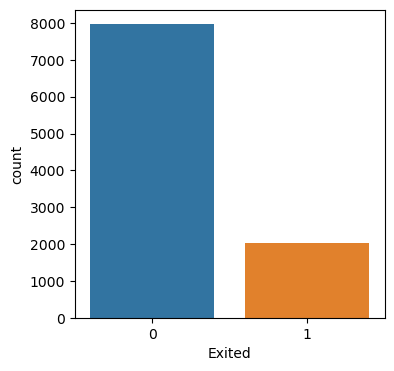

In [52]:
plt.figure(figsize=(4,4))
sns.countplot(x='Exited',data=df)

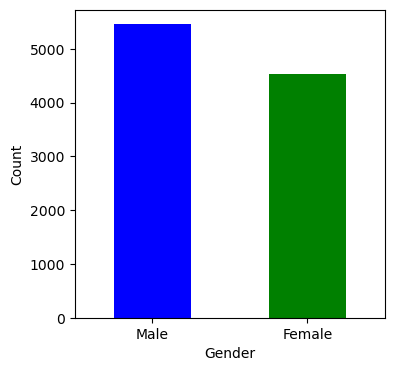

In [53]:
plt.figure(figsize=(4,4))
df['Gender'].value_counts().plot.bar(color=['b', 'g'])
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

 **Bank has more males customer than females**

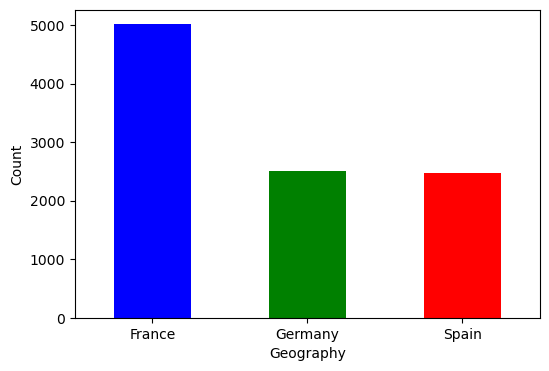

In [54]:
plt.figure(figsize=(6,4))
df['Geography'].value_counts().plot.bar(color=['b', 'g', 'r'])
plt.ylabel('Count')
plt.xlabel('Geography')
plt.xticks(rotation=0)
plt.show()

**Majority of customers are from France**

### Churn Segmentation by Gender

In [55]:
# Segment "Exited" by gender and display the frequency and percentage within each class
group_count = df.groupby('Gender')['Exited'].agg(Count='value_counts')
group_count

Count
Gender Exited       
Female 0        3404
       1        1139
Male   0        4559
       1         898

In [56]:
# dataframe for plotting count
df_group= group_count
df_group = df_group.pivot_table(values='Count', index='Gender', columns=['Exited'])
df_group

Exited,0,1
Gender,,
Female,3404,1139
Male,4559,898


In [57]:
# Calculate percentage within each class
df_group = group_count.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
df_group.rename(columns={'Count': 'Percentage'}, inplace=True)
df_group

Percentage
Gender Gender Exited            
Female Female 0            74.93
              1            25.07
Male   Male   0            83.54
              1            16.46

In [58]:
# Reorganize dataframe for plotting percentage
df_group = df_group.pivot_table(values='Percentage', index='Gender', columns=['Exited'])
df_group

Exited,0,1
Gender,,
Female,74.93,25.07
Male,83.54,16.46


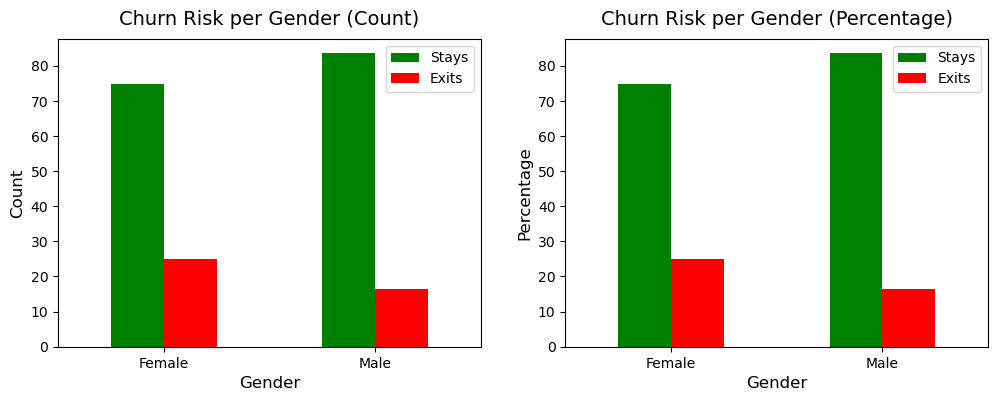

In [59]:
# Churn distribution by gender, count + percentage

labels= ['Stays', 'Exits']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_group.plot(kind='bar',
          color=['g', 'r'],
          rot=0, 
          ax=ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Gender (Count)', fontsize=14, pad=10)
ax1.set_ylabel('Count',size=12)
ax1.set_xlabel('Gender', size=12)


df_group.plot(kind='bar',
          color=['g', 'r'],
          rot=0, 
          ax=ax2)
ax2.legend(labels)
ax2.set_title('Churn Risk per Gender (Percentage)', fontsize=14, pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Gender', size=12)

plt.show()

**The count and percentage for Exiting is more among females than males**

In [60]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.0,1,1,1,101348.88,1


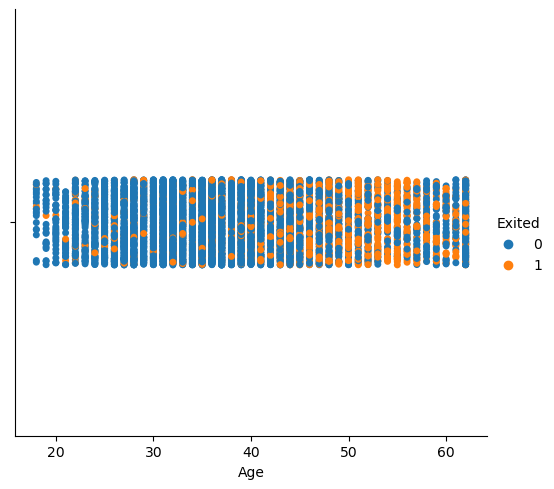

In [61]:
sns.catplot(x='Age',hue='Exited',data=df)

**People with age around 50-60 are more likely to leave the bank**

([<matplotlib.patches.Wedge at 0x296c7ef7010>,
 [Text(0.3412091840810337, 1.045741981895513, 'Germany'),
  Text(-0.8962571161403855, -0.6377485254923917, 'France'),
  Text(0.8843014545578098, -0.6542254485014644, 'Spain')],
 [Text(0.18611410040783652, 0.5704047173975525, '39.96'),
  Text(-0.4888675178947557, -0.3478628320867591, '39.76'),
  Text(0.4823462479406235, -0.3568502446371623, '20.27')])

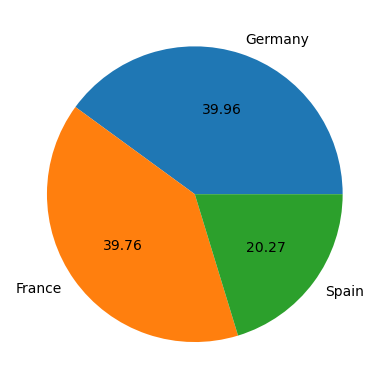

In [62]:
churn_data=df[df['Exited']==1]
plt.pie(churn_data['Geography'].value_counts(),labels=churn_data['Geography'].value_counts().index,autopct='%.2f')

**Germany has high number of Exited population followed by france and Spain**

**So the authorities should look into the rules and compare with other countries to find out where they are lagging behind so that they can improve**

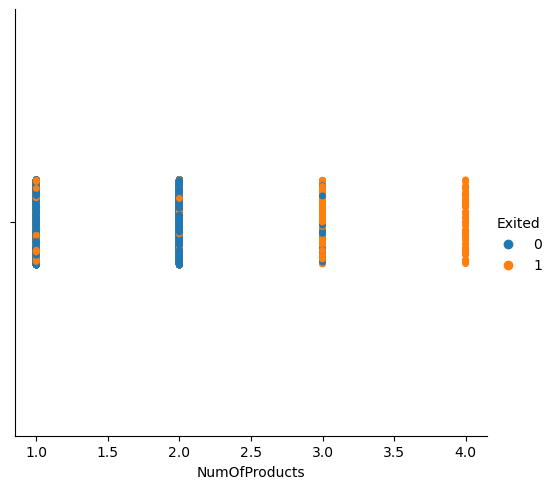

In [63]:
sns.catplot(x='NumOfProducts',hue='Exited',data=df)

**People who have more number of products from bank are more likely to leave**

**This may be due to low quality of products provided by banks.So,bank should maintain the quality of products they are providing to their customers**

<Axes: xlabel='HasCrCard', ylabel='IsActiveMember'>

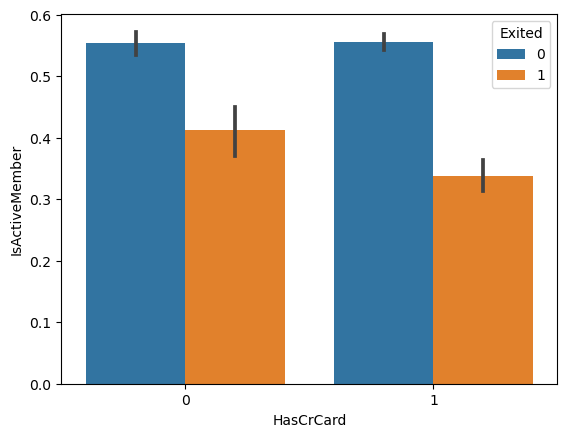

In [64]:
sns.barplot(x='HasCrCard',y='IsActiveMember',hue='Exited',data=df)

**People not having Credit Card are more likely to leave the bank**

**Credit Card act as bridge between Bank and customers maintaining relationships between them**

In [65]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.0,1,1,1,101348.88,1


<Axes: xlabel='IsActiveMember', ylabel='Density'>

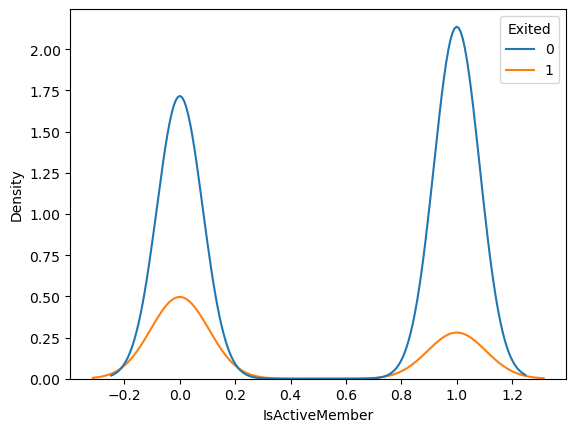

In [66]:
sns.kdeplot(x='IsActiveMember',hue='Exited',data=df)

**People who are not active member or less actively participating in bank activity(transactions etc.) are more likely to churn**

**We should keep a note of such people and communicate with them so that they can be provided with better solutions**

<Axes: xlabel='CreditScore', ylabel='Density'>

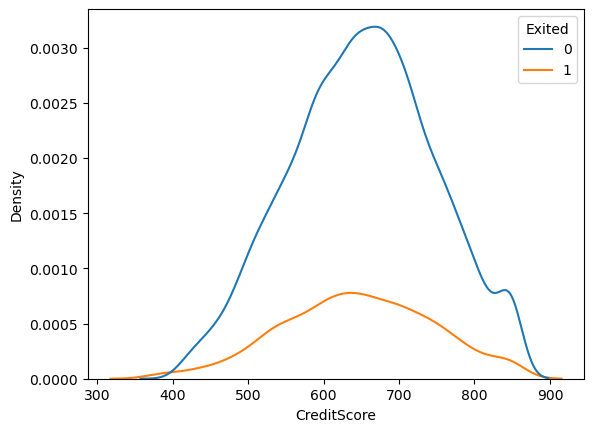

In [67]:
sns.kdeplot(x='CreditScore',hue='Exited',data=df)

**People having less credit score are more likely to churn**

**Low credit score occur when customer is not regular with loan repayments,in such a case bank should consult with such people what is the issue such people are facing and try to reduce their monthly interests so that credit score could be improved and these prople are less likely to churn**

In [68]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.0,1,1,1,101348.88,1


<Axes: xlabel='Tenure', ylabel='Density'>

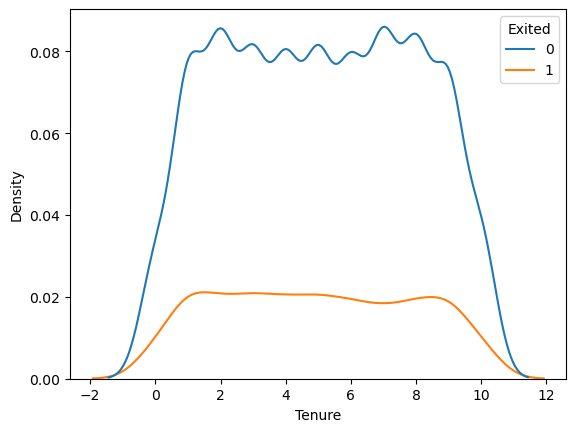

In [69]:
sns.kdeplot(x='Tenure',hue='Exited',data=df)

**Less duration of tenure shows more Exited rate**

<Axes: xlabel='Tenure', ylabel='count'>

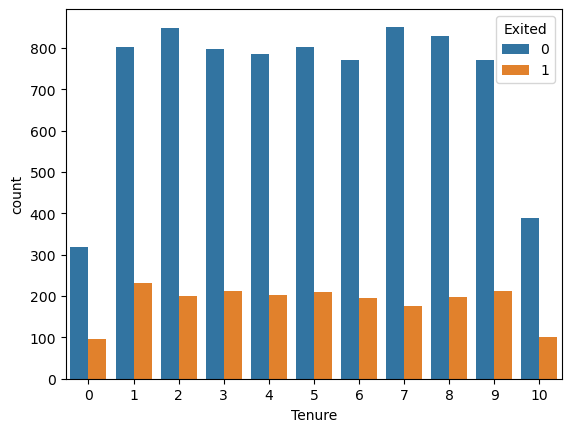

In [70]:
sns.countplot(x='Tenure',hue='Exited',data=df)

**People with less tenure with bank are exiting from banks**

**So bank should focus on to increase the tenure of people coming their**

In [72]:
# drop columns
#df.drop(['RowNumber', 'Surname'], axis=1, inplace=True)
#df.columns

In [73]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.0,1,1,1,101348.88,1


In [ ]:
df.drop(['CustomerId'],axis=1,inplace=True)

In [74]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.0,1,1,1,101348.88,1


## Outliers

In [75]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [76]:
columns=['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited']

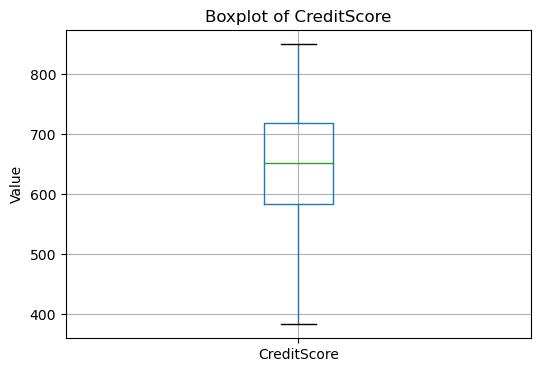

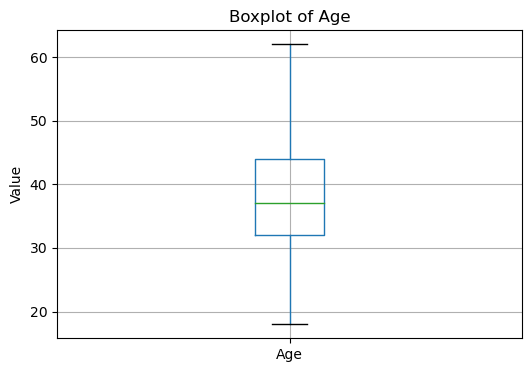

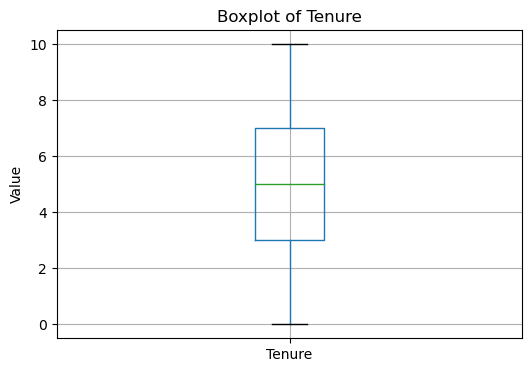

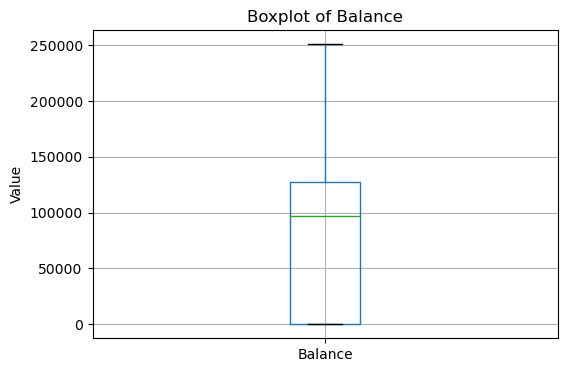

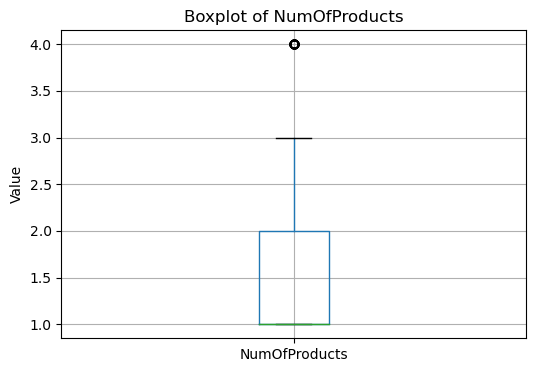

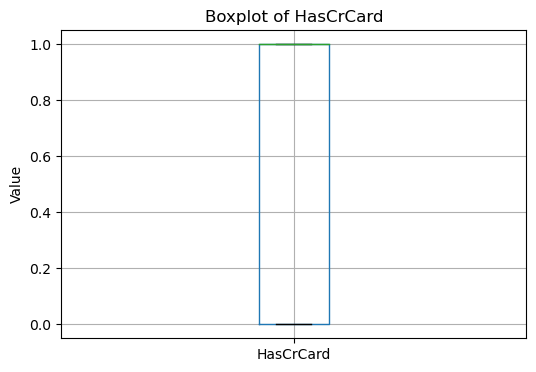

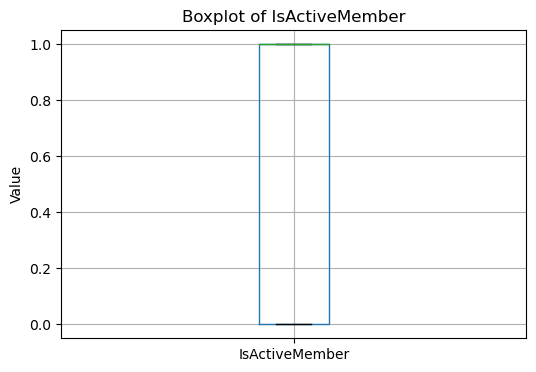

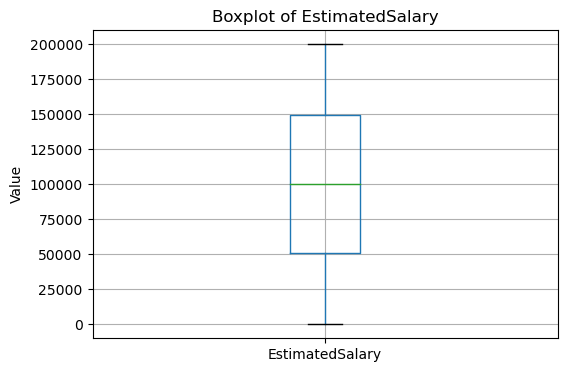

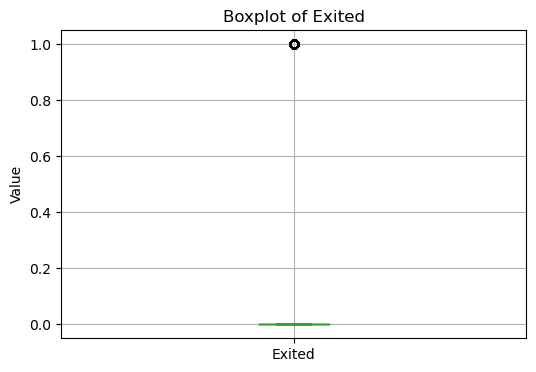

In [79]:
for feature in columns:
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
    df.boxplot(column=feature)
    plt.title(f'Boxplot of {feature}')
    plt.ylabel('Value')
    plt.show()

### Age and Credit Score have Outliers 

## Looking at distribution to remove outliers

CreditScore : -0.06425547313963796


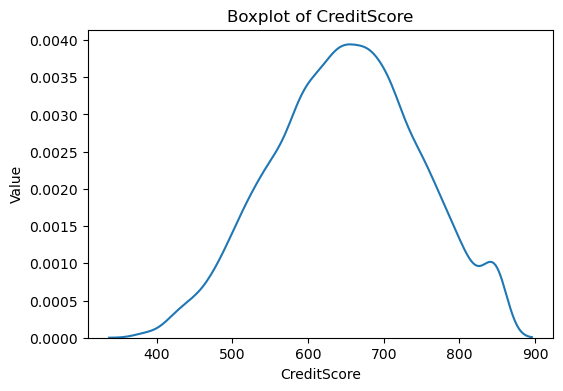

Age : 0.630314700010664


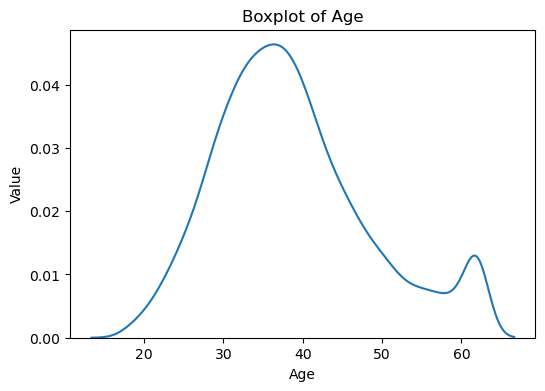

Tenure : 0.01099145797717904


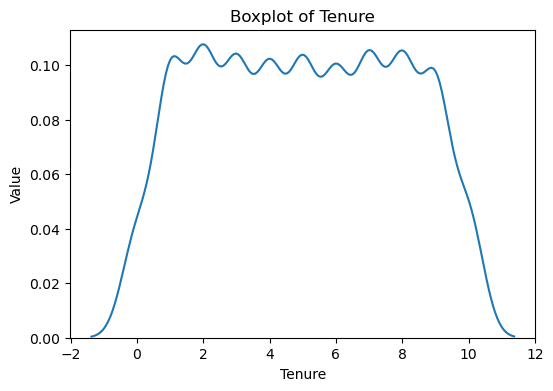

Balance : -0.14110871094154384


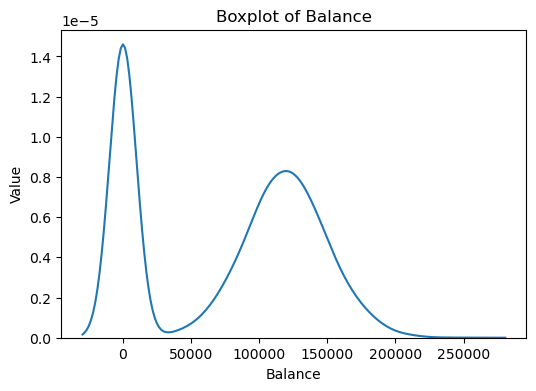

NumOfProducts : 0.7455678882823168


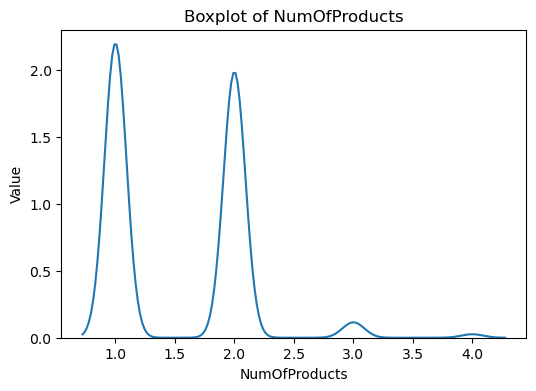

HasCrCard : -0.9018115952400578


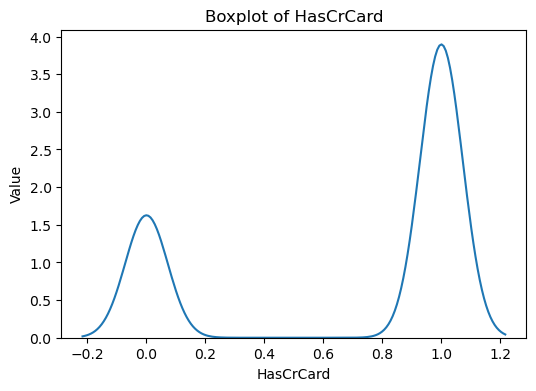

IsActiveMember : -0.06043662833499078


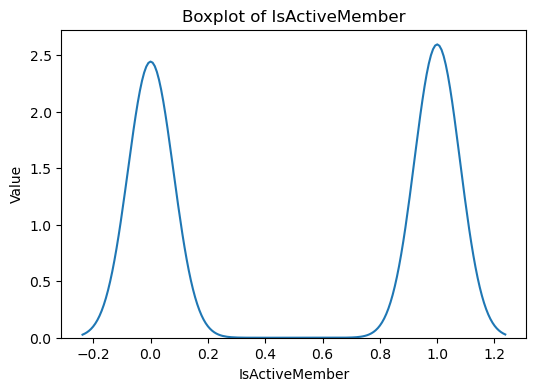

EstimatedSalary : 0.0020853576615585162


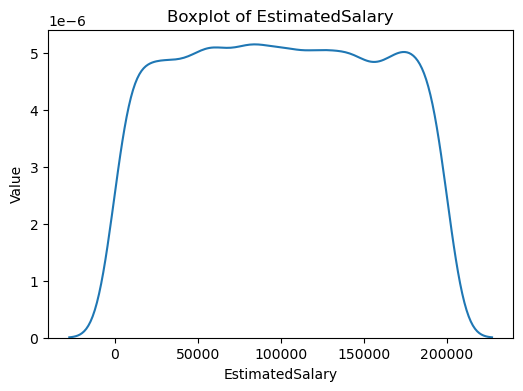

Exited : 1.4716106649378211


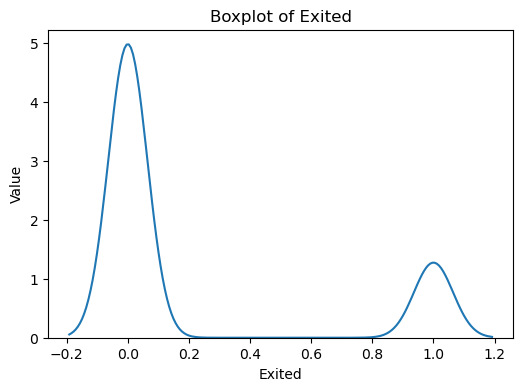

In [80]:
for feature in columns:
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
    sns.kdeplot(data=df,x=feature)
    plt.title(f'Boxplot of {feature}')
    plt.ylabel('Value')
    print(feature,":",df[feature].skew())
    plt.show()

In [81]:
# Based on skewness and above kdeplot we find Age and Credit Score has a skewed distribution 

## Using IQR method to remove outliers

In [82]:
feature_with_outlier=['Age','CreditScore']

In [83]:
s=[]
for feature in feature_with_outlier:
    q1=df[feature].quantile(0.25)
    q3=df[feature].quantile(0.75)
    iqr=q3-q1
    upper_bridge=q3+1.5*iqr
    lower_bridge=q1-1.5*iqr
    l=upper_bridge,lower_bridge
    print(feature,':',df[feature].skew())
    s.append(l)
print(s)    

Age : 0.630314700010664
CreditScore : -0.06425547313963796
[(62.0, 14.0), (919.0, 383.0)]


In [84]:
s=[(62.0, 14.0), (919.0, 383.0)]
def impute(df, feature_with_outlier, s):
    for idx, feature in enumerate(feature_with_outlier):
        upper_bridge, lower_bridge = s[idx]
        df[feature] = np.where(df[feature] > upper_bridge, upper_bridge,
                                np.where(df[feature] < lower_bridge, lower_bridge,
                                         df[feature]))

In [85]:
impute(df, ['Age', 'CreditScore'], s)

Age : 0.630314700010664


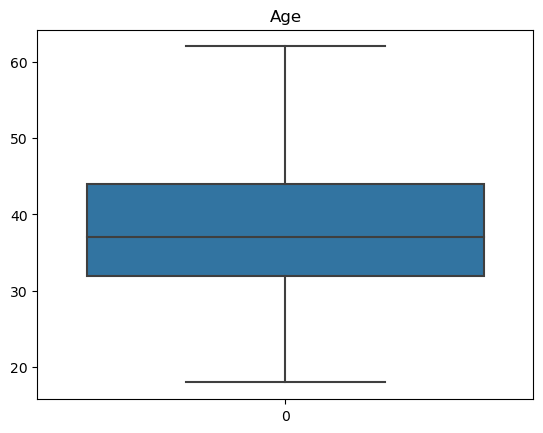

CreditScore : -0.06425547313963796


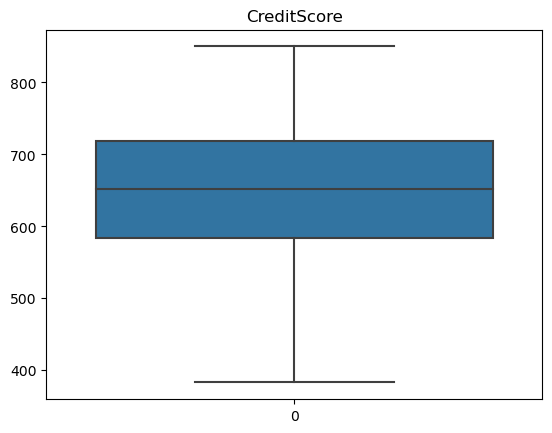

In [86]:
for feat in feature_with_outlier:
    sns.boxplot(df[feat])
    plt.title(feat)
    print(feat,":",df[feat].skew())
    plt.show()

# Separating data into dependent and independent feature

In [87]:
X=df.iloc[:,:-1]
y=df['Exited']

# Splitting data into train and test

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=0)

In [90]:
(X_train.shape),(X_test.shape),(y_train.shape)

((8000, 10), (2000, 10), (8000,))

# Feature Engineering

## Missing Values

In [91]:
X_train.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

# Categorical Columns

In [92]:
# identify categorical columns in the DataFrame
category = [i for i in X_train.columns if X_train[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(X_train[col].value_counts())
    print()

Geography
France     4008
Germany    2004
Spain      1988
Name: count, dtype: int64

Gender
Male      4368
Female    3632
Name: count, dtype: int64



In [93]:
# show category columns
df[category].columns

Index(['Geography', 'Gender'], dtype='object')

# One hot Encoding

In [94]:
X_train=pd.get_dummies(data=X_train,columns=['Geography','Gender'],drop_first=True)

In [95]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
493,531.0,47.0,6,0.00,1,0,0,194998.34,False,False,False
6839,724.0,36.0,6,94615.11,2,1,1,10627.21,True,False,True
170,484.0,29.0,4,130114.39,1,1,0,164017.89,False,False,False
4958,655.0,37.0,6,109093.41,2,1,0,1775.52,False,False,True
4271,465.0,33.0,5,0.00,2,0,1,78698.09,False,False,True


In [96]:
X_train=X_train.rename(columns={'Gender_Male':'gender','Geography_Germany':'germany','Geography_Spain':'spain'})

In [97]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,germany,spain,gender
493,531.0,47.0,6,0.00,1,0,0,194998.34,False,False,False
6839,724.0,36.0,6,94615.11,2,1,1,10627.21,True,False,True
170,484.0,29.0,4,130114.39,1,1,0,164017.89,False,False,False
4958,655.0,37.0,6,109093.41,2,1,0,1775.52,False,False,True
4271,465.0,33.0,5,0.00,2,0,1,78698.09,False,False,True


# Feature Scaling

In [98]:
from sklearn.preprocessing import MinMaxScaler as MMS

In [99]:
scaler=MMS()

In [100]:
X_train = scaler.fit_transform(X_train)

In [101]:
X_train

array([[0.31691649, 0.65909091, 0.6       , ..., 0.        , 0.        ,
        0.        ],
       [0.73019272, 0.40909091, 0.6       , ..., 1.        , 0.        ,
        1.        ],
       [0.21627409, 0.25      , 0.4       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46680942, 0.68181818, 0.9       , ..., 1.        , 0.        ,
        1.        ],
       [0.72591006, 0.38636364, 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.77087794, 0.15909091, 0.6       , ..., 0.        , 1.        ,
        1.        ]])

# Feature Engineering for test dataset

## Missing Values

In [102]:
X_test.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## Categorical Columns

In [103]:
#identify categorical columns in the DataFrame
category = [i for i in X_test.columns if X_test[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(X_test[col].value_counts())
    print()

Geography
France     1006
Germany     505
Spain       489
Name: count, dtype: int64

Gender
Male      1089
Female     911
Name: count, dtype: int64



# One hot Encoding

In [104]:
X_test=pd.get_dummies(data=X_test,columns=['Geography','Gender'],drop_first=True)

In [105]:
X_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1344,460.0,40.0,6,119507.58,2,1,0,91560.63,True,False,False
8167,713.0,24.0,7,147687.24,1,1,1,121592.50,True,False,False
4747,663.0,62.0,6,0.00,2,0,1,15876.52,False,True,True
5004,502.0,57.0,3,101465.31,1,1,0,43568.31,True,False,False
3124,760.0,39.0,6,178585.46,1,1,0,67131.30,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
9107,655.0,38.0,9,0.00,1,0,1,90490.33,False,True,True
8249,586.0,38.0,6,0.00,2,1,1,37935.83,False,False,False
8337,534.0,41.0,9,0.00,2,1,0,13871.34,False,False,True
6279,757.0,55.0,9,117294.12,4,1,0,94187.47,False,True,False


In [106]:
X_test=X_test.rename(columns={'Gender_Male':'gender','Geography_Germany':'germany','Geography_Spain':'spain'})

In [107]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,germany,spain,gender
1344,460.0,40.0,6,119507.58,2,1,0,91560.63,True,False,False
8167,713.0,24.0,7,147687.24,1,1,1,121592.50,True,False,False
4747,663.0,62.0,6,0.00,2,0,1,15876.52,False,True,True
5004,502.0,57.0,3,101465.31,1,1,0,43568.31,True,False,False
3124,760.0,39.0,6,178585.46,1,1,0,67131.30,False,False,True


# Feature Scaling

In [108]:
X_test = scaler.transform(X_test)
X_test

array([[0.16488223, 0.5       , 0.6       , ..., 1.        , 0.        ,
        0.        ],
       [0.70663812, 0.13636364, 0.7       , ..., 1.        , 0.        ,
        0.        ],
       [0.59957173, 1.        , 0.6       , ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.32334047, 0.52272727, 0.9       , ..., 0.        , 0.        ,
        1.        ],
       [0.80085653, 0.84090909, 0.9       , ..., 0.        , 1.        ,
        0.        ],
       [0.7751606 , 0.29545455, 0.3       , ..., 0.        , 1.        ,
        0.        ]])

## Correlation

In [109]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

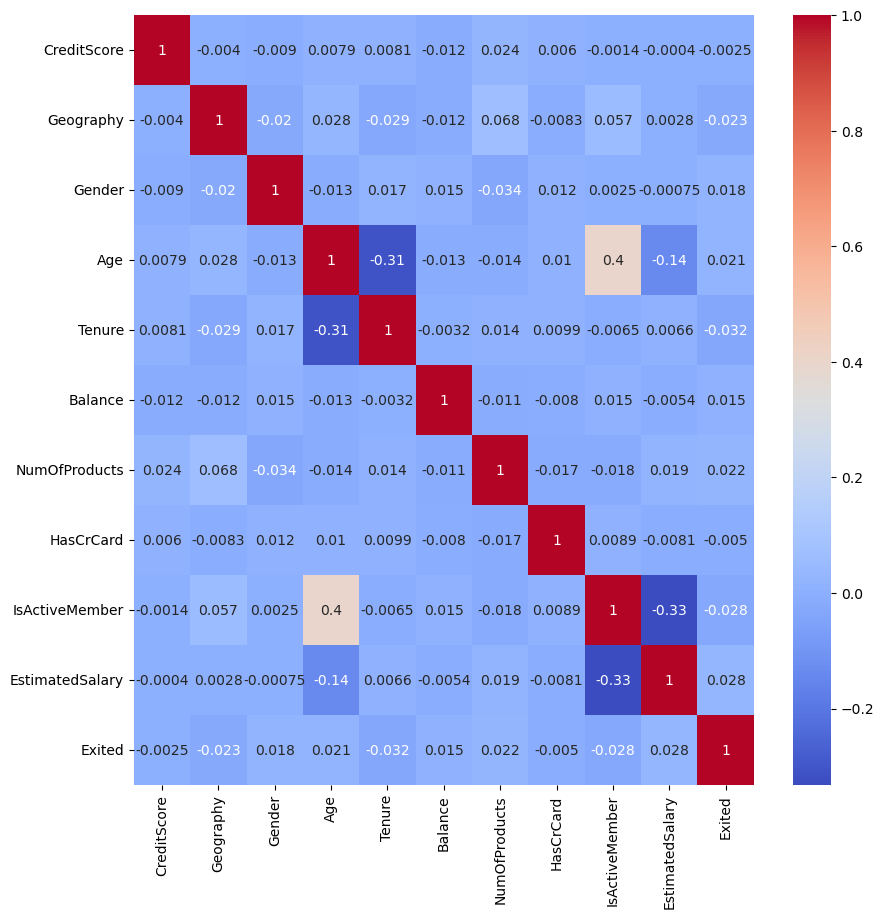

In [110]:
X_train_df = pd.DataFrame(X_train, columns=['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'])  # Replace 'feature1', 'feature2', etc. with your actual feature names

# Calculate the correlation matrix
cor = X_train_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

**The graph above shows that there are not many features that are strongly correlated linearly with the target. This means that most of the correlations contained in the dataset are non-linear. Based on this, the appropriate model to use is a model that has good performance on datasets that have many non-linear correlations such as Naive Bayes,Decision Trees, Gradient Boosting and Support Vector Machines (SVM)**.

# Solving Imbalance of Dataset

In [111]:
from collections import Counter
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_resampled).items()))

[(0, 6370), (1, 1630)]
[(0, 6370), (1, 6702)]


# Model Building

In [112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
# splitting data and model evaluation
from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer,accuracy_score ,classification_report, confusion_matrix
# cross-validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Naive Bayes

In [113]:
# initialize the Naive Bayes classifier and fit it to the resampled training data

NB_classifier = GaussianNB()
NB_classifier.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = NB_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.7518427518427518
ROC-AUC Score: 0.7167876659402084
Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1593
           1       0.38      0.75      0.50       407

    accuracy                           0.70      2000
   macro avg       0.65      0.72      0.64      2000
weighted avg       0.81      0.70      0.72      2000

Confusion Matrix:

 [[1086  507]
 [ 101  306]]


# Cross Validation

In [114]:
# initialize a K-Fold cross-validation object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# compute the cross-validation recall scores and ROC-AUC scores for the untuned NB classifier
nb_cv_recall_scores = cross_val_score(NB_classifier, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
nb_cv_roc_auc_scores = cross_val_score(NB_classifier, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", nb_cv_recall_scores)
print("ROC-AUC  :", nb_cv_roc_auc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.7046696598653689
ROC-AUC  : 0.7726469579420411


In [115]:
print(NB_classifier.get_params())

{'priors': None, 'var_smoothing': 1e-09}


# Hyperparameter Tuning

In [116]:
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

# initialize GridSearchCV objects for recall and ROC-AUC score
grid_recall = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='recall')
grid_roc_auc = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for recall and ROC-AUC score
grid_recall.fit(X_resampled, y_resampled)
grid_roc_auc.fit(X_resampled, y_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             scoring='roc_auc')

In [117]:
best_hyperparams_recall = grid_recall.best_params_
best_hyperparams_roc_auc = grid_roc_auc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print(best_hyperparams_recall)

print(best_hyperparams_roc_auc)

nb_cv_recall_scores = grid_recall.best_score_
nb_cv_roc_auc_scores = grid_roc_auc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall   :", nb_cv_recall_scores)
print("ROC-AUC  :", nb_cv_roc_auc_scores)

best_nb_model = grid_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
{'var_smoothing': 1e-09}
{'var_smoothing': 1e-09}

The cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:
Recall   : 0.7046696598653689
ROC-AUC  : 0.7726469579420411


In [118]:
best_nb_fit_for_train_data_recall = cross_val_score(best_nb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_nb_fit_for_train_data_rocauc = cross_val_score(best_nb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_nb_fit_for_train_data_recall)
print("ROC-AUC  :", best_nb_fit_for_train_data_rocauc)

best_nb_fit_for_test_data_recall = cross_val_score(best_nb_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_nb_fit_for_test_data_rocauc = cross_val_score(best_nb_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Test Data")
print("Recall   :", best_nb_fit_for_test_data_recall)
print("ROC-AUC  :", best_nb_fit_for_test_data_rocauc)

Train Data
Recall   : 0.7046696598653689
ROC-AUC  : 0.7726469579420411
Test Data
Recall   : 0.826
ROC-AUC  : 0.787101996453319


# Decision Tree

In [119]:
# initialize the Decision Tree classifier and fit it to the resampled training data
DT = DecisionTreeClassifier()
DT.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = DT.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.48402948402948404
ROC-AUC Score: 0.6663713019645223
Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1593
           1       0.45      0.48      0.47       407

    accuracy                           0.77      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.78      0.77      0.78      2000

Confusion Matrix:

 [[1352  241]
 [ 210  197]]


# Cross Validation

In [120]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned DT classifier
dt_before_tuned_cv_recall_scores = cross_val_score(DT, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
dt_before_tuned_cv_rocauc_scores = cross_val_score(DT, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned  after a 10 fold cross validation:")
print("Recall   :", dt_before_tuned_cv_recall_scores)
print("ROC-AUC  :", dt_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned  after a 10 fold cross validation:
Recall   : 0.853120626078482
ROC-AUC  : 0.845046212813618


In [121]:
print(DT.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


# Hyperparameter Tuning

In [122]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# initialize GridSearchCV objects for recall and ROC-AUC score
grid_dt_recall = GridSearchCV(DT, param_grid, cv=kf, n_jobs=-1, scoring='recall')
grid_dt_rocauc = GridSearchCV(DT, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for recall and ROC-AUC score
grid_dt_recall.fit(X_resampled, y_resampled)
grid_dt_rocauc.fit(X_resampled, y_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [123]:
best_hyperparams_recall = grid_dt_recall.best_params_
best_hyperparams_rocauc = grid_dt_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

dt_after_tuned_cv_recall_scores = grid_dt_recall.best_score_
dt_after_tuned_cv_rocauc_scores = grid_dt_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned  after a 10 fold cross validation:")
print("Recall :", dt_after_tuned_cv_recall_scores)
print("ROC-AUC  :", dt_after_tuned_cv_rocauc_scores)

best_dt_model = grid_dt_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
Recall :
 {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
ROC-AUC  :
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}

The cross-validation recall and ROC-AUC score for tuned  after a 10 fold cross validation:
Recall : 0.8594712028654936
ROC-AUC  : 0.9047734074157183


In [124]:
best_dt_fit_for_train_data_recall = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_dt_fit_for_train_data_rocauc = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_dt_fit_for_train_data_recall)
print("ROC-AUC  :", best_dt_fit_for_train_data_rocauc)

best_dt_fit_for_test_data_recall = cross_val_score(best_dt_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_dt_fit_for_test_data_rocauc = cross_val_score(best_dt_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_dt_fit_for_test_data_recall)
print("ROC-AUC  :", best_dt_fit_for_test_data_rocauc)

Train Data
Recall   : 0.8561593802762528
ROC-AUC  : 0.8491697993610542
Test Data
Recall   : 0.7934999999999999
ROC-AUC  : 0.675460575554389


# Random Forest Classifier

In [125]:
# initialize the Random Forest classifier and fit it to the resampled training data
Clf=RFC()
Clf.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = Clf.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.5872235872235873
ROC-AUC Score: 0.7383701112514672
Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1593
           1       0.58      0.59      0.58       407

    accuracy                           0.83      2000
   macro avg       0.73      0.74      0.74      2000
weighted avg       0.83      0.83      0.83      2000

Confusion Matrix:

 [[1417  176]
 [ 168  239]]


# Cross Validation

In [126]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned classifier
rf_before_tuned_cv_recall_scores = cross_val_score(Clf, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
rf_before_tuned_cv_rocauc_scores = cross_val_score(Clf, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", rf_before_tuned_cv_recall_scores)
print("ROC-AUC  :", rf_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.9206529044205374
ROC-AUC  : 0.9662890990895597


In [127]:
print(Clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Hyperparameter Tuning

In [ ]:
parameter={'n_estimators' : [int(x) for x in np.linspace(start=100,stop=400,num=30)],

# Number of features to consider at every split
'max_features' :[0.2,0.6,1.0],

# Maximum number of levels in tree
'max_depth':[2,8,None],

# Number of samples
'max_samples' : [0.5,0.75,1.0],

# Bootstrap samples
'bootstrap' : [True,False],

# Minimum number of samples required to split a node
'min_samples_split' : [2, 5],

# Minimum number of samples required at each leaf node
'min_samples_leaf' : [1, 2]}

# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_rf_recall = RandomizedSearchCV(Clf, parameter, cv=kf, n_jobs=-1, scoring='recall')
random_rf_rocauc = RandomizedSearchCV(Clf, parameter, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform  randomized search for recall and ROC-AUC score
random_rf_recall.fit(X_resampled, y_resampled)
random_rf_rocauc.fit(X_resampled, y_resampled)

In [ ]:
best_hyperparams_recall = random_rf_recall.best_params_
best_hyperparams_rocauc = random_rf_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

rf_after_tuned_cv_recall_scores = random_rf_recall.best_score_
rf_after_tuned_cv_rocauc_scores = random_rf_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", rf_after_tuned_cv_recall_scores)
print("ROC-AUC  :", rf_after_tuned_cv_rocauc_scores)

best_rf_model = random_rf_recall.best_estimator_

In [ ]:
best_rf_fit_for_train_data_recall = cross_val_score(best_rf_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_rf_fit_for_train_data_rocauc = cross_val_score(best_rf_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_rf_fit_for_train_data_recall)
print("ROC-AUC  :", best_rf_fit_for_train_data_rocauc)

best_rf_fit_for_test_data_recall = cross_val_score(best_rf_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_rf_fit_for_test_data_rocauc = cross_val_score(best_rf_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_rf_fit_for_test_data_recall)
print("ROC-AUC  :", best_rf_fit_for_test_data_rocauc)

# Xgboost Classifier

In [ ]:
# initialize the XGB classifier and fit it to the resampled training data
XGB=XGBClassifier()
XGB.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = XGB.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

# Cross Validation

In [ ]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned DT classifier
xgb_before_tuned_cv_recall_scores = cross_val_score(XGB, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
xgb_before_tuned_cv_rocauc_scores = cross_val_score(XGB, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", xgb_before_tuned_cv_recall_scores)
print("ROC-AUC  :", xgb_before_tuned_cv_rocauc_scores)

In [ ]:
print(XGB.get_params())

# Hyperparameter Tuning

In [ ]:
params={'eta':[0.004,0.006,0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3],
           'gamma':[5,10,15,20,25,30,40,50,60,70,80,90,100],
           'max_depth':[int(x) for x in np.linspace(5,30,num=6)],
           'min_child_weight':[3,4,5,6,7],
           'subsample':[0.6,0.7,0.8]}

# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_xgb_recall = RandomizedSearchCV(XGB, params, cv=kf, n_jobs=-1, scoring='recall')
random_xgb_rocauc = RandomizedSearchCV(XGB, params, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform Randomized search for recall and ROC-AUC score
random_xgb_recall.fit(X_resampled, y_resampled)
random_xgb_rocauc.fit(X_resampled, y_resampled)

In [ ]:
best_hyperparams_recall = random_xgb_recall.best_params_
best_hyperparams_rocauc = random_xgb_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

xgb_after_tuned_cv_recall_scores = random_xgb_recall.best_score_
xgb_after_tuned_cv_rocauc_scores = random_xgb_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", xgb_after_tuned_cv_recall_scores)
print("ROC-AUC  :", xgb_after_tuned_cv_rocauc_scores)

best_dt_model = random_xgb_recall.best_estimator_

In [ ]:
best_xgb_fit_for_train_data_recall = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_xgb_fit_for_train_data_rocauc = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_xgb_fit_for_train_data_recall)
print("ROC-AUC  :", best_xgb_fit_for_train_data_rocauc)

best_xgb_fit_for_test_data_recall = cross_val_score(best_dt_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_xgb_fit_for_test_data_rocauc = cross_val_score(best_dt_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_xgb_fit_for_test_data_recall)
print("ROC-AUC  :", best_xgb_fit_for_test_data_rocauc)

# Logistic Regression

In [ ]:
# initialize the Logistic Regression and fit it to the resampled training data

lgc=LogisticRegression()
lgc.fit(X_resampled, y_resampled)
# make predictions on the test data
y_pred = lgc.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

# Cross Validation

In [ ]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned Logistic Regression
lgc_before_tuned_cv_recall_scores = cross_val_score(lgc, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
lgc_before_tuned_cv_rocauc_scores = cross_val_score(lgc, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", lgc_before_tuned_cv_recall_scores)
print("ROC-AUC  :", lgc_before_tuned_cv_rocauc_scores)

# Hyperparameter Tuning

In [ ]:
param={'penalty':['l1','l2','elasticnet'],'C':[1,2,3,4,5,6,10,20,30,40,50],
      'max_iter':[100,200,300]}
# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_lgc_recall = RandomizedSearchCV(lgc, param, cv=kf, n_jobs=-1, scoring='recall')
random_lgc_rocauc = RandomizedSearchCV(lgc, param, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform randomized search for recall and ROC-AUC score
random_lgc_recall.fit(X_resampled, y_resampled)
random_lgc_rocauc.fit(X_resampled, y_resampled)

In [ ]:
best_hyperparams_recall = random_lgc_recall.best_params_
best_hyperparams_rocauc = random_lgc_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

lgc_after_tuned_cv_recall_scores = random_lgc_recall.best_score_
lgc_after_tuned_cv_rocauc_scores = random_lgc_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", lgc_after_tuned_cv_recall_scores)
print("ROC-AUC  :", lgc_after_tuned_cv_rocauc_scores)

best_lgc_model = random_lgc_recall.best_estimator_

In [ ]:
best_lgc_fit_for_train_data_recall = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_lgc_fit_for_train_data_rocauc = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_lgc_fit_for_train_data_recall)
print("ROC-AUC  :", best_lgc_fit_for_train_data_rocauc)

best_lgc_fit_for_test_data_recall = cross_val_score(best_dt_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_lgc_fit_for_test_data_rocauc = cross_val_score(best_dt_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_lgc_fit_for_test_data_recall)
print("ROC-AUC  :", best_lgc_fit_for_test_data_rocauc)

# Best Model

In [ ]:
dict_result = {'Model' :['Naive Bayes', 'Decision Tree','RandomForest', 'XgBoost','LogisticReg'],
                "Recall (train)": [best_nb_fit_for_train_data_recall, best_dt_fit_for_train_data_recall, best_xgb_fit_for_train_data_recall,best_rf_fit_for_train_data_recall,best_lgc_fit_for_train_data_recall],
                "Recall (test)": [best_nb_fit_for_test_data_recall, best_dt_fit_for_test_data_recall, best_xgb_fit_for_test_data_recall,best_rf_fit_for_test_data_recall,best_lgc_fit_for_test_data_recall],
                "ROC-AUC (train)": [best_nb_fit_for_train_data_rocauc, best_dt_fit_for_train_data_rocauc, best_xgb_fit_for_train_data_rocauc,best_rf_fit_for_train_data_rocauc,best_lgc_fit_for_train_data_rocauc],
                "ROC-AUC (test)": [best_nb_fit_for_test_data_rocauc, best_dt_fit_for_test_data_rocauc, best_xgb_fit_for_test_data_rocauc,best_rf_fit_for_train_data_rocauc,best_lgc_fit_for_train_data_rocauc]}

model_result = pd.DataFrame(dict_result).sort_values(by=['Recall (test)'], ascending= False).reset_index(drop=True)
model_result

**In this problem false negatives are important so recall should be higher**

**Model with high recall is best one**

## Model with high recall for train and test is Xgboost . And hence this model is best

# ROC-AUC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = best_dt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()